# Part 1 : Dataset Preparation and exploration

### First part is installing the data through kaggle without local download

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset
License(s): other


In [4]:
!unzip stanford-dogs-dataset.zip -d /content/stanford-dogs-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: /content/stanford-dogs-dataset/images/Images/n02108089-boxer/n02108089_12827.j

In [5]:
!ls /content/stanford-dogs-dataset

annotations  images


## Dataset is downloaded and now we can implement pytorch and necessary libraries to load it into our code

In [6]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset,SubsetRandomSampler
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import collections
from PIL import Image
import PIL
import math
import random
from collections import Counter
import io


In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Defining Paths & Loading data:

In [8]:
BASE_PATH = '/content/stanford-dogs-dataset/'
IMAGE_DIR = os.path.join(BASE_PATH, 'images/Images')
ANNOTATION_DIR = os.path.join(BASE_PATH, 'annotations/Annotation')

In [9]:
basic_transform = transforms.ToTensor()

full_dataset_imagefolder = ImageFolder(root=IMAGE_DIR, transform=basic_transform)


class_names = full_dataset_imagefolder.classes
class_to_idx = full_dataset_imagefolder.class_to_idx
print(f"Found {len(full_dataset_imagefolder)} images in {len(class_names)} classes using ImageFolder.")
print(f"Example class name: {class_names[0]}") # e.g., n02085620-Chihuahua

Found 20580 images in 120 classes using ImageFolder.
Example class name: n02085620-Chihuahua


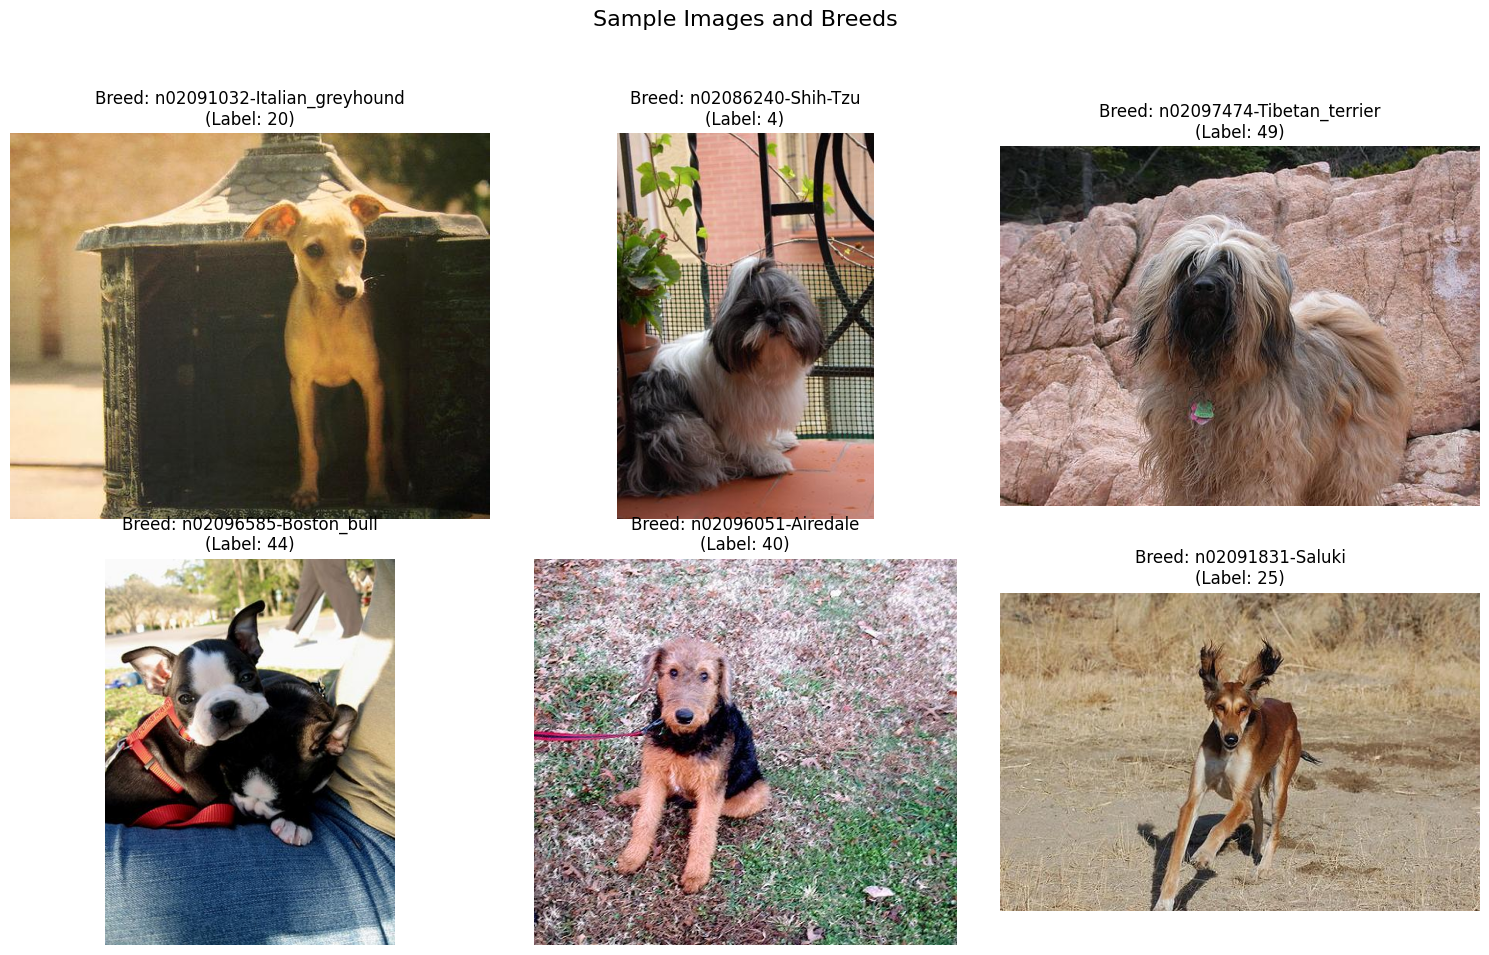

In [10]:
# Get a few random samples
num_samples_to_show = 6
# Ensure we don't request more samples than available
num_samples_to_show = min(num_samples_to_show, len(full_dataset_imagefolder))
sample_indices = random.sample(range(len(full_dataset_imagefolder)), num_samples_to_show)

# Determine grid size
cols = 3
rows = math.ceil(num_samples_to_show / cols)

plt.figure(figsize=(5 * cols, 5 * rows))
plt.suptitle("Sample Images and Breeds", fontsize=16)

for i, idx in enumerate(sample_indices):
    # Get image path and label index
    img_path, label_idx = full_dataset_imagefolder.samples[idx]  # Access samples directly
    breed_name = full_dataset_imagefolder.classes[label_idx] # Get breed name using classes

    # Load the image using PIL directly for visualization
    try:
        img_pil = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Warning: Could not load image {img_path} for visualization: {e}")
        continue

    # Plotting
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_pil)
    plt.title(f"Breed: {breed_name}\n(Label: {label_idx})")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

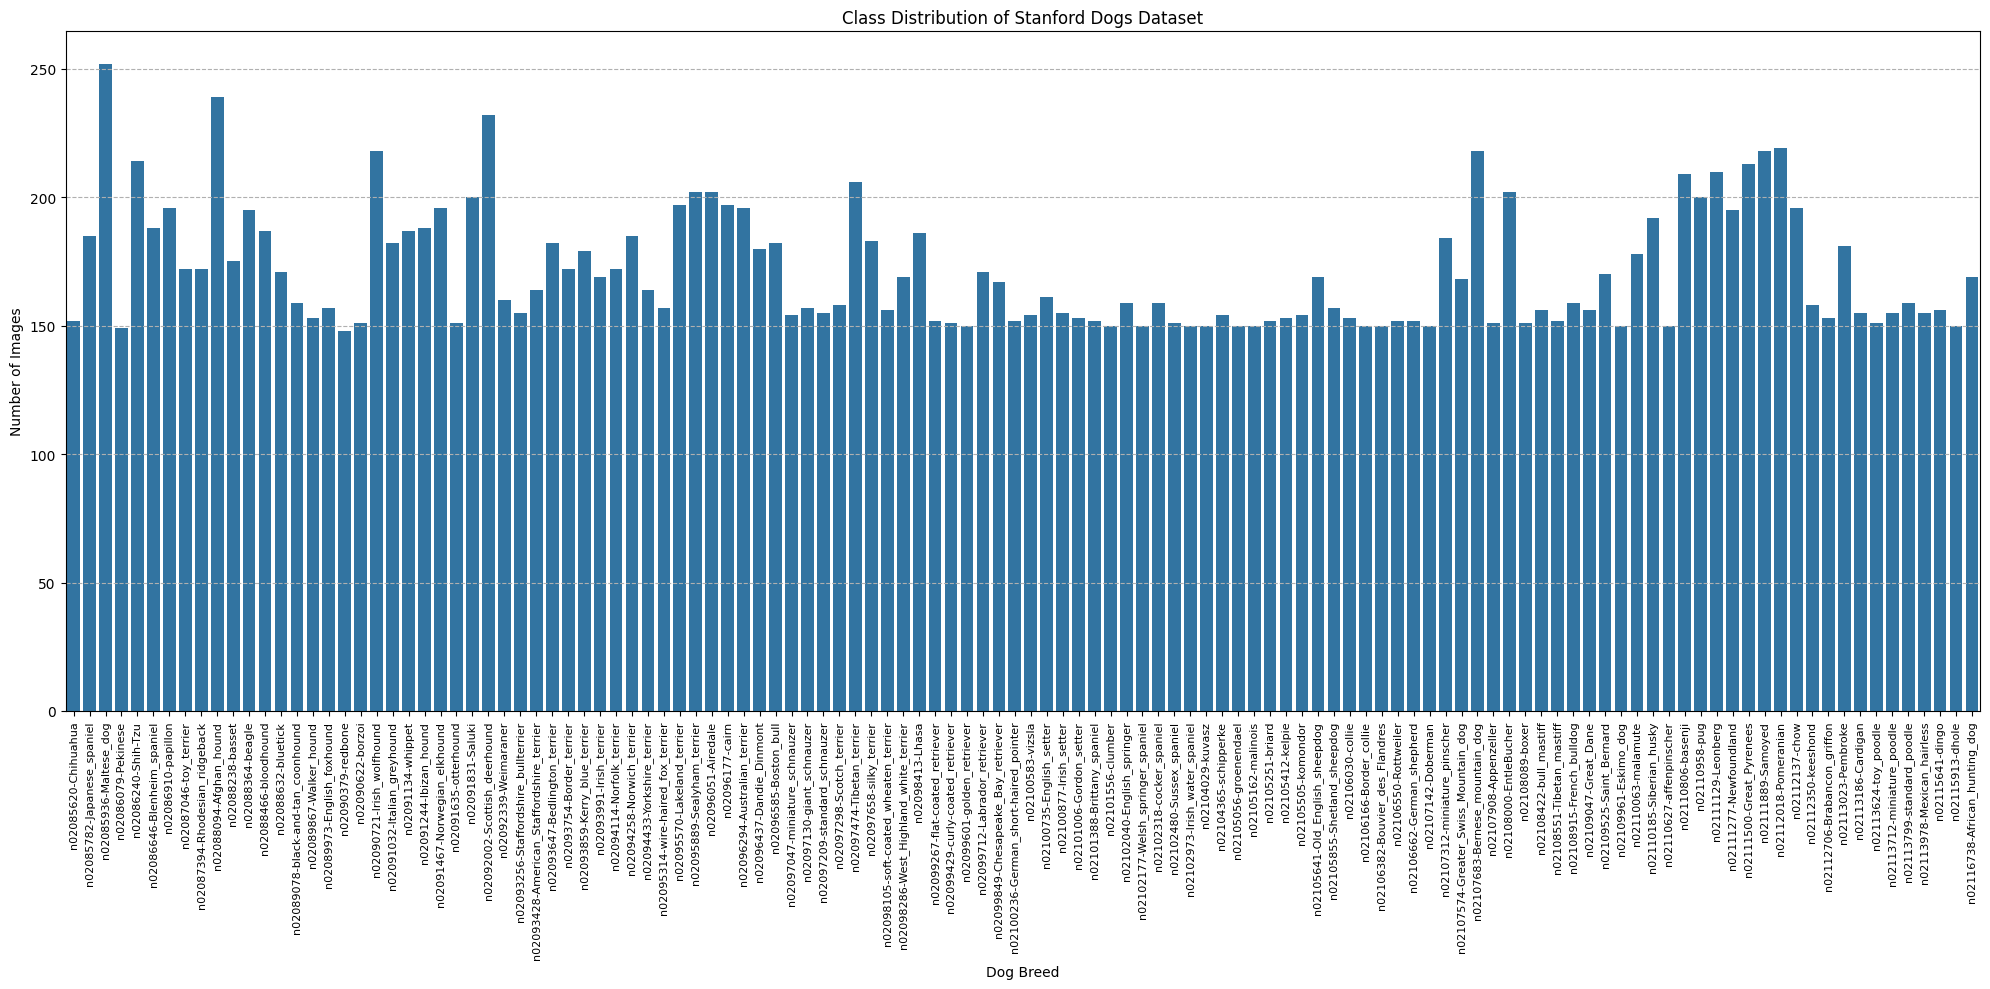


Class Distribution Summary:
 - Total classes: 120
 - Minimum images per class: 148
 - Maximum images per class: 252
 - Average images per class: 171.50
 - Max/Min Ratio: 1.70
 -> Appears relatively balanced.


In [11]:
all_labels = [label for _, label in full_dataset_imagefolder.samples] # extract labels from samples
label_counts = Counter(all_labels)

# Get breed names for plotting
breed_names = [full_dataset_imagefolder.classes[i] for i in sorted(label_counts.keys())]  # Use classes attribute
counts = [label_counts[i] for i in sorted(label_counts.keys())]

plt.figure(figsize=(20, 10)) # Adjust size as needed
sns.barplot(x=breed_names, y=counts)
plt.title('Class Distribution of Stanford Dogs Dataset')
plt.xlabel('Dog Breed')
plt.ylabel('Number of Images')
plt.xticks(rotation=90, fontsize=8) # Rotate labels
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Print statistics
min_count = min(counts)
max_count = max(counts)
avg_count = np.mean(counts)
print(f"\nClass Distribution Summary:")
print(f" - Total classes: {len(breed_names)}")
print(f" - Minimum images per class: {min_count}")
print(f" - Maximum images per class: {max_count}")
print(f" - Average images per class: {avg_count:.2f}")
# Simple check for imbalance
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
print(f" - Max/Min Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 2.5: # Slightly adjusted threshold
    print(" -> Suggests moderate class imbalance.")
elif imbalance_ratio > 5:
     print(" -> Suggests significant class imbalance.")
else:
    print(" -> Appears relatively balanced.")

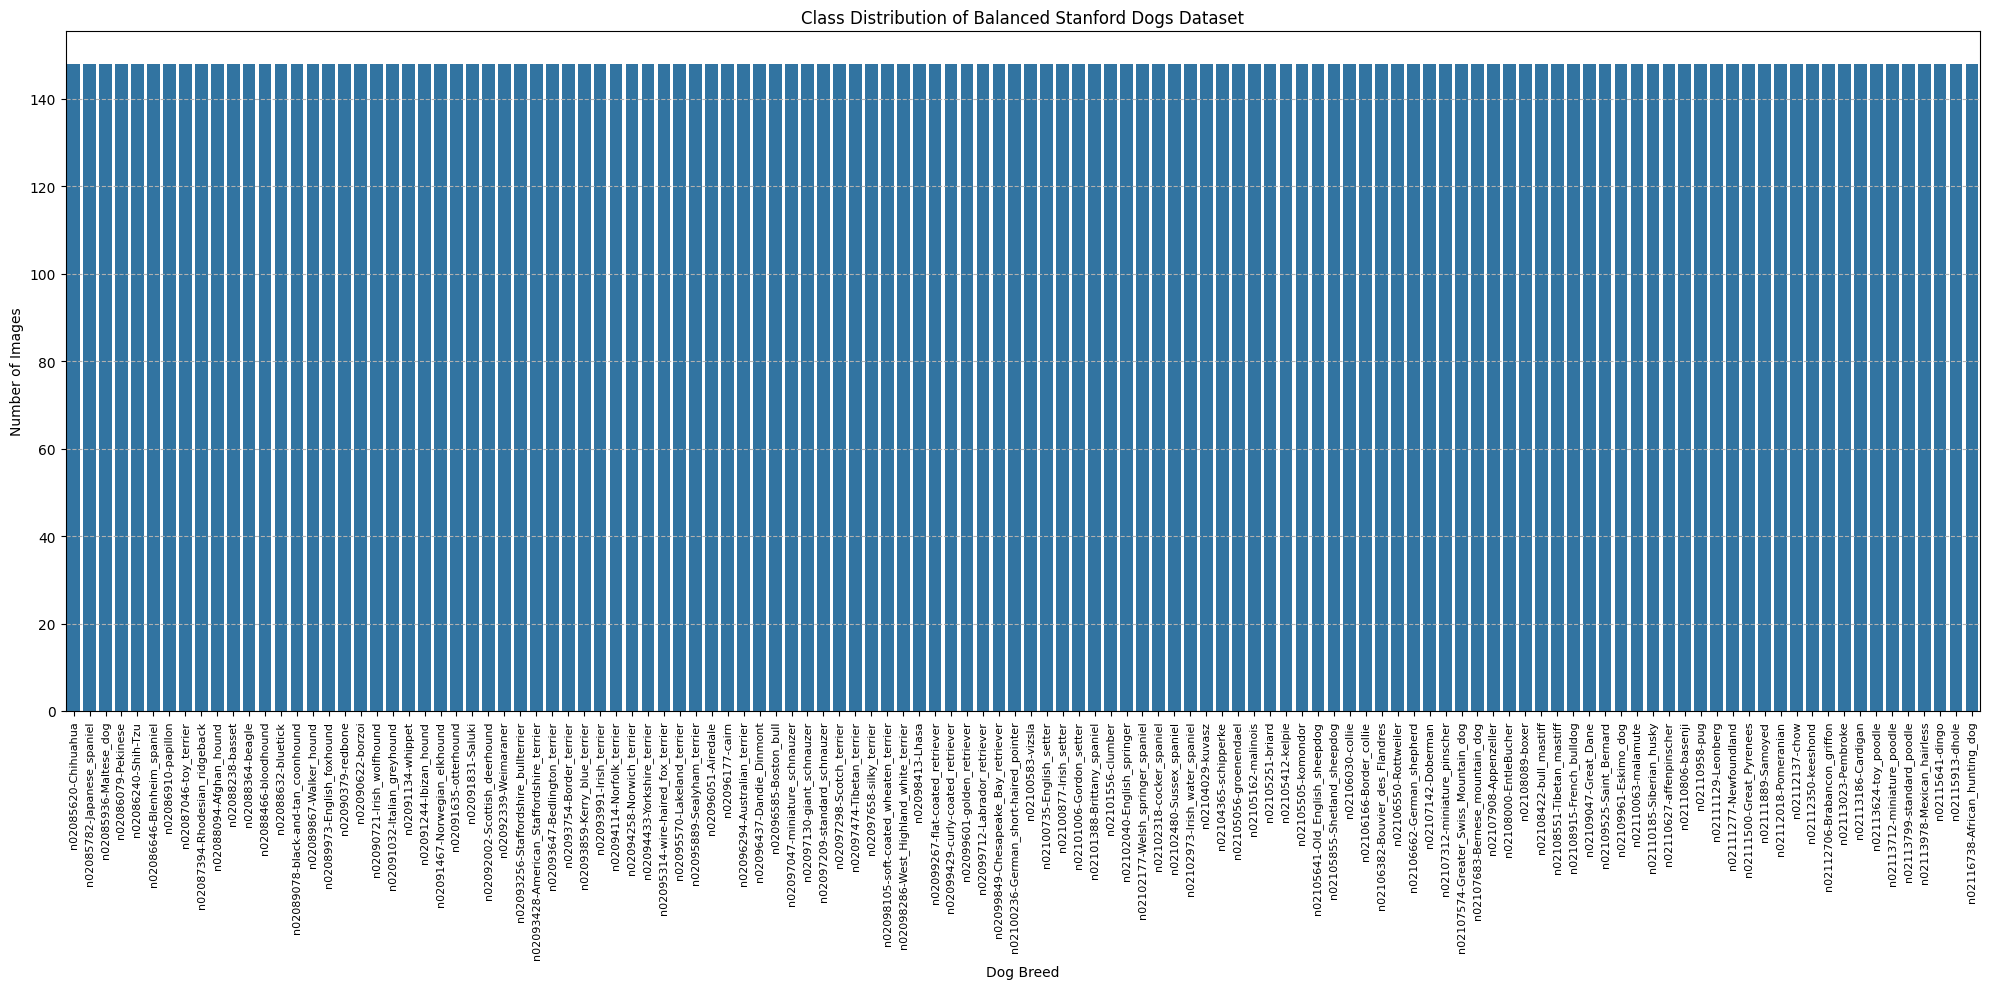


Balanced Class Distribution Summary:
 - Total classes: 120
 - Minimum images per class: 148
 - Maximum images per class: 148
 - Average images per class: 148.00
 - Max/Min Ratio: 1.00
 -> Dataset is now balanced.

Balanced dataset created with 17760 total images
 - Training set: 14208 images
 - Validation set: 3552 images


In [12]:
def balance_dataset(dataset):
    """
    Balance a dataset by undersampling majority classes to match the minority class.

    Args:
        dataset: An ImageFolder dataset

    Returns:
        List of indices for a balanced dataset
    """
    # Extract labels from the dataset
    labels = [label for _, label in dataset.samples]
    label_counts = Counter(labels)

    # Find the minimum count (minority class)
    min_count = min(label_counts.values())

    # Create a dictionary to store indices for each class
    class_indices = {i: [] for i in range(len(dataset.classes))}

    # Populate the dictionary with indices
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)

    # Randomly select min_count samples from each class
    balanced_indices = []
    for label, indices in class_indices.items():
        # Randomly sample min_count indices (or all if less than min_count)
        sampled_indices = random.sample(indices, min(min_count, len(indices)))
        balanced_indices.extend(sampled_indices)

    # Shuffle the indices
    random.shuffle(balanced_indices)

    return balanced_indices

# Apply the balancing function
balanced_indices = balance_dataset(full_dataset_imagefolder)

# Create a balanced subset
from torch.utils.data import Subset
balanced_dataset = Subset(full_dataset_imagefolder, balanced_indices)

# Count labels in the balanced dataset
balanced_labels = [full_dataset_imagefolder.samples[i][1] for i in balanced_indices]
balanced_label_counts = Counter(balanced_labels)

# Get breed names for plotting
balanced_breed_names = [full_dataset_imagefolder.classes[i] for i in sorted(balanced_label_counts.keys())]
balanced_counts = [balanced_label_counts[i] for i in sorted(balanced_label_counts.keys())]

# Visualize the balanced dataset
plt.figure(figsize=(20, 10))
sns.barplot(x=balanced_breed_names, y=balanced_counts)
plt.title('Class Distribution of Balanced Stanford Dogs Dataset')
plt.xlabel('Dog Breed')
plt.ylabel('Number of Images')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Print statistics for balanced dataset
min_count_balanced = min(balanced_counts)
max_count_balanced = max(balanced_counts)
avg_count_balanced = np.mean(balanced_counts)
print(f"\nBalanced Class Distribution Summary:")
print(f" - Total classes: {len(balanced_breed_names)}")
print(f" - Minimum images per class: {min_count_balanced}")
print(f" - Maximum images per class: {max_count_balanced}")
print(f" - Average images per class: {avg_count_balanced:.2f}")
# Check for imbalance
imbalance_ratio_balanced = max_count_balanced / min_count_balanced if min_count_balanced > 0 else float('inf')
print(f" - Max/Min Ratio: {imbalance_ratio_balanced:.2f}")
print(" -> Dataset is now balanced.")

# Now you can use this balanced dataset for training
# For example:
train_size = int(0.8 * len(balanced_dataset))
val_size = len(balanced_dataset) - train_size
balanced_train_dataset, balanced_val_dataset = random_split(balanced_dataset, [train_size, val_size])

# Create data loaders with the balanced datasets
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
balanced_val_loader = DataLoader(balanced_val_dataset, batch_size=32)

print(f"\nBalanced dataset created with {len(balanced_dataset)} total images")
print(f" - Training set: {len(balanced_train_dataset)} images")
print(f" - Validation set: {len(balanced_val_dataset)} images")

### Data is relatively balanced with similar values for all classes. Chosen target size was also because it is optimal for MobilenetV2


Analyzing dimensions of 20580 images...


Analyzing images:   0%|          | 0/20580 [00:00<?, ?it/s]

Analysis complete.


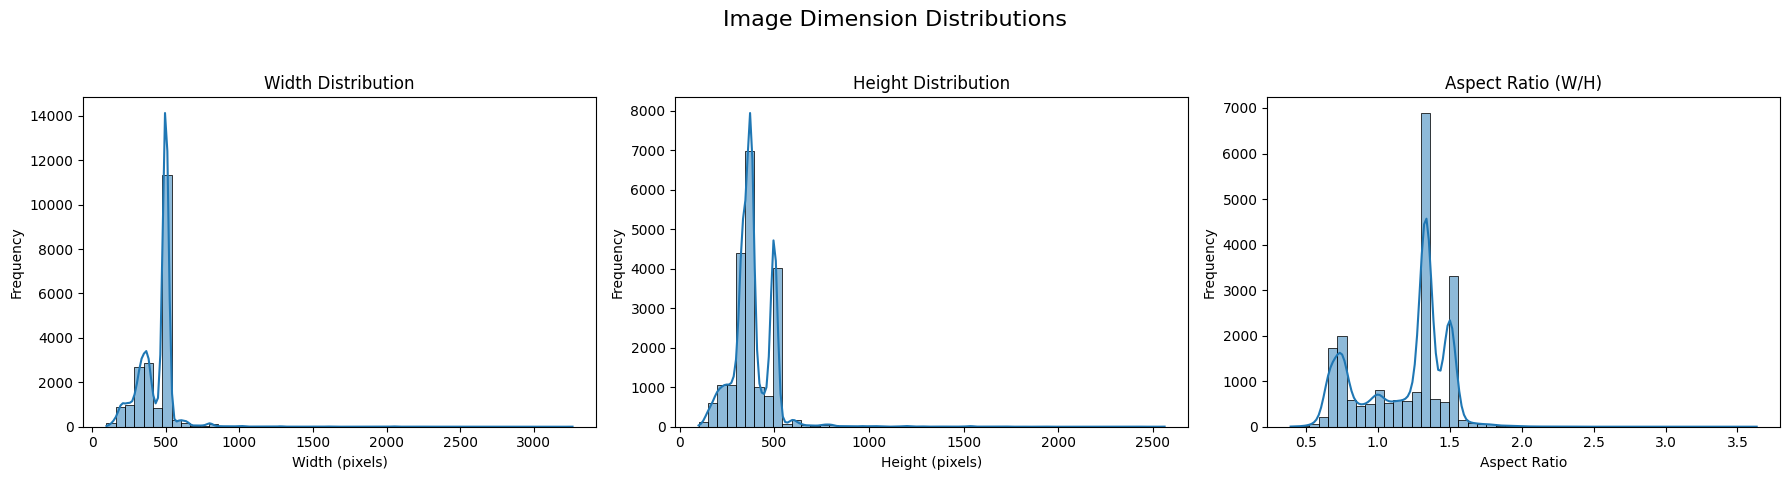


Image Dimension Summary:
 - Width (px): Min=97, Max=3264, Avg=442.5
 - Height (px): Min=100, Max=2562, Avg=385.9
 - Aspect Ratio: Min=0.39, Max=3.63, Avg=1.19

Chosen TARGET_SIZE for resizing: (224, 224)


In [13]:
image_paths = [sample[0] for sample in full_dataset_imagefolder.samples]  # Access image paths from samples
heights = []
widths = []
aspect_ratios = []

print(f"Analyzing dimensions of {len(image_paths)} images...")
# Use a progress indicator for large datasets (optional but good practice)
from tqdm.notebook import tqdm # Use tqdm for progress bar in Colab/Jupyter

for img_path in tqdm(image_paths, desc="Analyzing images"):
    try:
        # Use 'with' statement for better resource management
        with Image.open(img_path) as img:
            width, height = img.size
            if width > 0 and height > 0: # Basic sanity check
                widths.append(width)
                heights.append(height)
                aspect_ratios.append(width / height)
            else:
                 print(f"Warning: Invalid dimensions (W:{width}, H:{height}) for {img_path}")
    except Exception as e:
        print(f"Warning: Could not read size for {img_path}: {e}")

print("Analysis complete.")

if not widths or not heights:
    print("Error: No valid image dimensions found. Cannot plot distributions.")
else:
    # Plot histograms
    plt.figure(figsize=(18, 5))
    plt.suptitle("Image Dimension Distributions", fontsize=16)

    plt.subplot(1, 3, 1)
    sns.histplot(widths, bins=50, kde=True)
    plt.title('Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    sns.histplot(heights, bins=50, kde=True)
    plt.title('Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    sns.histplot(aspect_ratios, bins=50, kde=True)
    plt.title('Aspect Ratio (W/H)')
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Print statistics
    print("\nImage Dimension Summary:")
    print(f" - Width (px): Min={min(widths)}, Max={max(widths)}, Avg={np.mean(widths):.1f}")
    print(f" - Height (px): Min={min(heights)}, Max={max(heights)}, Avg={np.mean(heights):.1f}")
    print(f" - Aspect Ratio: Min={min(aspect_ratios):.2f}, Max={max(aspect_ratios):.2f}, Avg={np.mean(aspect_ratios):.2f}")


TARGET_SIZE = (224, 224) # MobileNetV2
print(f"\nChosen TARGET_SIZE for resizing: {TARGET_SIZE}")

### Splitting the data:

In [14]:

from sklearn.model_selection import train_test_split
from torchvision import transforms

# --- Parameters ---
NORM_MEAN = [0.485, 0.456, 0.406] # ImageNet stats
NORM_STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 128
# --- Basic Transform for Validation/Test ---
val_test_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)])

# --- Data Splitting (Stratified 70/15/15) ---
all_indices = list(range(len(full_dataset_imagefolder)))
all_labels = full_dataset_imagefolder.targets

# Split into Train (70%) and  (30% -> Val + Test)
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    all_indices, all_labels, test_size=0.30, random_state=SEED, stratify=all_labels)
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_labels, test_size=0.50, random_state=SEED, stratify=temp_labels)

print(f"\nDataset split details:")
print(f" - Total samples:    {len(full_dataset_imagefolder)}")
print(f" - Training samples: {len(train_indices)} ({len(train_indices)/len(full_dataset_imagefolder)*100:.1f}%)")
print(f" - Validation samples: {len(val_indices)} ({len(val_indices)/len(full_dataset_imagefolder)*100:.1f}%)")
print(f" - Test samples:     {len(test_indices)} ({len(test_indices)/len(full_dataset_imagefolder)*100:.1f}%)")
print(f" - Sum of splits:    {len(train_indices) + len(val_indices) + len(test_indices)}")




Dataset split details:
 - Total samples:    20580
 - Training samples: 14406 (70.0%)
 - Validation samples: 3087 (15.0%)
 - Test samples:     3087 (15.0%)
 - Sum of splits:    20580


### Data augmentation :

In [15]:
train_transform = transforms.Compose([
    # Resize the shorter side while maintaining aspect ratio
    transforms.Resize(256),
    # Random crop to final size
    transforms.RandomCrop(224),
    # Keep your existing horizontal flip
    transforms.RandomHorizontalFlip(),
    # Keep your existing rotation
    transforms.RandomRotation(10),
    # Add color jittering for lighting variations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Add random affine transformation for more variety
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # Keep your existing ToTensor and Normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    # Resize the shorter side while maintaining aspect ratio
    transforms.Resize(256),
    # Center crop to get consistent area for evaluation
    transforms.CenterCrop(224),
    # Keep your existing ToTensor and Normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Training Transform defined.")
print("\n--- Training Transforms ---")
print(train_transform)
print("\n--- Validation/Test Transforms ---")
print(val_transform)

Training Transform defined.

--- Training Transforms ---
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

--- Validation/Test Transforms ---
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### Transforming the data with dataloaders after splitting :

In [16]:
class TransformedDataset(Dataset):
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        img_path, label = self.base_dataset.samples[original_idx]

        # More robust image loading
        try:
            with open(img_path, 'rb') as f:
                img_bytes = f.read()
            img = PIL.Image.open(io.BytesIO(img_bytes)).convert('RGB')
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

            raise  # Re-raise the exception for debugging

        return img, label
val_test_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)])

# --- Data Splitting (Stratified 70/15/15) ---
all_indices = list(range(len(full_dataset_imagefolder)))
all_labels = full_dataset_imagefolder.targets

# Split into Train (70%) and  (30% -> Val + Test)
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    all_indices, all_labels, test_size=0.30, random_state=SEED, stratify=all_labels)
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_labels, test_size=0.50, random_state=SEED, stratify=temp_labels)

# Create SubsetRandomSamplers for train, val, and test
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(TransformedDataset(full_dataset_imagefolder, train_indices, transform=train_transform), batch_size=BATCH_SIZE)
val_loader = DataLoader(TransformedDataset(full_dataset_imagefolder, val_indices, transform=val_transform), batch_size=BATCH_SIZE)
test_loader = DataLoader(TransformedDataset(full_dataset_imagefolder, test_indices, transform=val_transform), batch_size=BATCH_SIZE)
print(f"\nDataset split details:")
print(f" - Total samples:    {len(full_dataset_imagefolder)}")
print(f" - Training samples: {len(train_indices)} ({len(train_indices)/len(full_dataset_imagefolder)*100:.1f}%)")
print(f" - Validation samples: {len(val_indices)} ({len(val_indices)/len(full_dataset_imagefolder)*100:.1f}%)")
print(f" - Test samples:     {len(test_indices)} ({len(test_indices)/len(full_dataset_imagefolder)*100:.1f}%)")
print(f" - Sum of splits:    {len(train_indices) + len(val_indices) + len(test_indices)}")

print(f"\nDataLoaders created with BATCH_SIZE={BATCH_SIZE}")
print(f" - Train batches: {len(train_loader)}")
print(f" - Val batches:   {len(val_loader)}")
print(f" - Test batches:  {len(test_loader)}")


Dataset split details:
 - Total samples:    20580
 - Training samples: 14406 (70.0%)
 - Validation samples: 3087 (15.0%)
 - Test samples:     3087 (15.0%)
 - Sum of splits:    20580

DataLoaders created with BATCH_SIZE=128
 - Train batches: 113
 - Val batches:   25
 - Test batches:  25


# Part 2 : CNN From scratch


### **Theory of Convolutional Neural Networks (CNNs)**:

Convolutional Neural Networks (CNNs) are widely used in image classification tasks, making them ideal for classifying fruits and vegetables. These models automatically learn spatial patterns, textures, and shapes in images, enabling accurate predictions without manual feature extraction.

#### **Key Components of CNNs**:

1. **Convolutional Layer**:  
   - Extracts features like edges, textures, and shapes by applying filters to the input image.  
   - Scans images through small patches, creating feature maps representing the presence of specific patterns.

2. **Activation Function**:  
   - Adds non-linearity to the model using **Batch Normalization**, enabling it to learn complex relationships in the data.

3. **Pooling Layer**:  
   - Reduces the spatial dimensions of feature maps through operations like max pooling, retaining essential information while decreasing computational complexity.  
   - Helps the model become invariant to minor changes in the input.

4. **Fully Connected Layer**:  
   - Integrates high-level features extracted by convolutional layers to make final predictions.  
   - Dense layers aggregate all learned information for classification tasks.

5. **Softmax Activation**:  
   - Converts the final output into a probability distribution for multi-class classification.  
   - Assigns a likelihood to each fruit or vegetable category.



### Simple CNN

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # First conv block - keep input channels small
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Second conv block - moderate increase in channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Third conv block - further increase channels
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Fourth conv block - final feature extraction
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Pooling, dropout and global pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)  # Reduced dropout rate for faster convergence
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Classifier
        self.fc = nn.Linear(128, num_classes)

        # Initialize weights for faster convergence
        self._initialize_weights()

    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Second block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Third block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Fourth block with dropout for regularization
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Global average pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        # Apply dropout before classification
        x = self.dropout(x)
        x = self.fc(x)

        return x

    def _initialize_weights(self):
        # Weight initialization for faster convergence
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

### Training Loop :

In [18]:
!pip install tqdm

import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    best_val_loss = float('inf')
    patience, patience_counter = 5, 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    print_every = 10  # Print every 10 batches

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training")):
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                if (batch_idx + 1) % print_every == 0:
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], "
                          f"Loss: {loss.item():.4f}")
            except Exception as e:
                print(f"Error during training (Epoch {epoch + 1}, Batch {batch_idx + 1}): {e}")
                print(f"Image shapes: {[img.shape for img in inputs]}")

                raise e

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        # Wrap your val_loader with tqdm
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss = val_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()

        # Early stopping and checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_cnn.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 120
model = SimpleCNN(num_classes).to(device)

train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, num_epochs=5, device=device
)

Epoch 1/5 Training:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1/5], Step [10/113], Loss: 4.8073
Epoch [1/5], Step [20/113], Loss: 4.8661
Epoch [1/5], Step [30/113], Loss: 4.8338
Epoch [1/5], Step [40/113], Loss: 4.8207
Epoch [1/5], Step [50/113], Loss: 4.7851
Epoch [1/5], Step [60/113], Loss: 4.7998
Epoch [1/5], Step [70/113], Loss: 4.7983
Epoch [1/5], Step [80/113], Loss: 4.7766
Epoch [1/5], Step [90/113], Loss: 4.8081
Epoch [1/5], Step [100/113], Loss: 4.7916
Epoch [1/5], Step [110/113], Loss: 4.8160


Epoch 1/5 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1: Train Loss 4.9266, Val Loss 4.7995, Train Acc 0.0095, Val Acc 0.0104


Epoch 2/5 Training:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2/5], Step [10/113], Loss: 4.8273
Epoch [2/5], Step [20/113], Loss: 4.8353
Epoch [2/5], Step [30/113], Loss: 4.8265
Epoch [2/5], Step [40/113], Loss: 4.8260
Epoch [2/5], Step [50/113], Loss: 4.7875
Epoch [2/5], Step [60/113], Loss: 4.8058
Epoch [2/5], Step [70/113], Loss: 4.7991
Epoch [2/5], Step [80/113], Loss: 4.7779
Epoch [2/5], Step [90/113], Loss: 4.8062
Epoch [2/5], Step [100/113], Loss: 4.7941
Epoch [2/5], Step [110/113], Loss: 4.8226


Epoch 2/5 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2: Train Loss 4.8065, Val Loss 4.7971, Train Acc 0.0092, Val Acc 0.0097


Epoch 3/5 Training:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3/5], Step [10/113], Loss: 4.8291
Epoch [3/5], Step [20/113], Loss: 4.8356
Epoch [3/5], Step [30/113], Loss: 4.8231
Epoch [3/5], Step [40/113], Loss: 4.8233
Epoch [3/5], Step [50/113], Loss: 4.7869
Epoch [3/5], Step [60/113], Loss: 4.8067
Epoch [3/5], Step [70/113], Loss: 4.8001
Epoch [3/5], Step [80/113], Loss: 4.7790
Epoch [3/5], Step [90/113], Loss: 4.8057
Epoch [3/5], Step [100/113], Loss: 4.7942
Epoch [3/5], Step [110/113], Loss: 4.8233


Epoch 3/5 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3: Train Loss 4.8064, Val Loss 4.7973, Train Acc 0.0096, Val Acc 0.0097


Epoch 4/5 Training:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4/5], Step [10/113], Loss: 4.8289
Epoch [4/5], Step [20/113], Loss: 4.8358
Epoch [4/5], Step [30/113], Loss: 4.8228
Epoch [4/5], Step [40/113], Loss: 4.8233
Epoch [4/5], Step [50/113], Loss: 4.7869
Epoch [4/5], Step [60/113], Loss: 4.8069
Epoch [4/5], Step [70/113], Loss: 4.8007
Epoch [4/5], Step [80/113], Loss: 4.7795
Epoch [4/5], Step [90/113], Loss: 4.8054
Epoch [4/5], Step [100/113], Loss: 4.7942
Epoch [4/5], Step [110/113], Loss: 4.8237


Epoch 4/5 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4: Train Loss 4.8066, Val Loss 4.7974, Train Acc 0.0095, Val Acc 0.0097


Epoch 5/5 Training:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5/5], Step [10/113], Loss: 4.8288
Epoch [5/5], Step [20/113], Loss: 4.8359
Epoch [5/5], Step [30/113], Loss: 4.8226
Epoch [5/5], Step [40/113], Loss: 4.8233
Epoch [5/5], Step [50/113], Loss: 4.7868
Epoch [5/5], Step [60/113], Loss: 4.8070
Epoch [5/5], Step [70/113], Loss: 4.8010
Epoch [5/5], Step [80/113], Loss: 4.7799
Epoch [5/5], Step [90/113], Loss: 4.8053
Epoch [5/5], Step [100/113], Loss: 4.7943
Epoch [5/5], Step [110/113], Loss: 4.8238


Epoch 5/5 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5: Train Loss 4.8067, Val Loss 4.7974, Train Acc 0.0096, Val Acc 0.0097


### When hyper parameter tuning best result was : 
Epoch 25: Train Loss 3.8828, Val Loss 3.7549, Train Acc 0.1348, Val Acc 0.1541
But it took 1 hour to train  which is not indicative of good performance and means CNN needs a more complex architecture that we will implement in transfer learning

### Loss& ACC Curves:

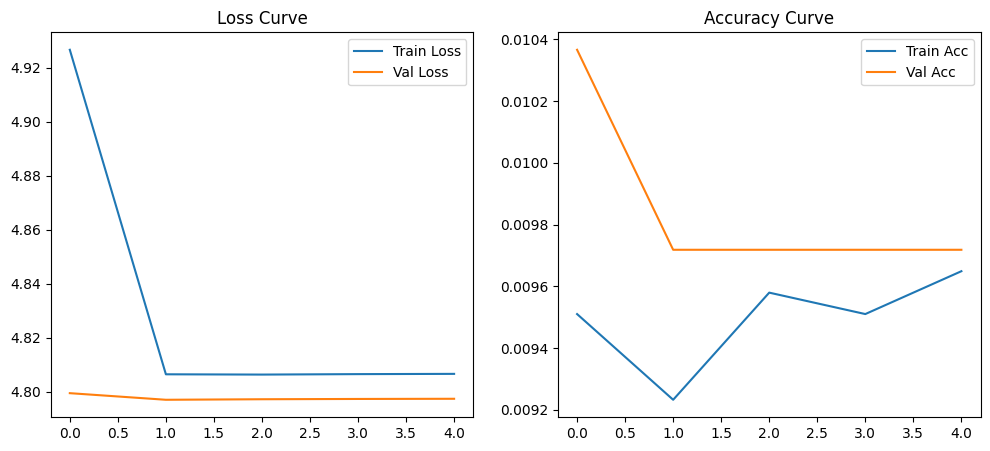

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_state_dict(torch.load('best_cnn.pth'))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00        38
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        32
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        29
           7       0.00      0.00      0.00        26
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00        36
          10       0.00      0.00      0.00        26
          11       0.00      0.00      0.00        29
          12       0.00      0.00      0.00        28
          13       0.00      0.00      0.00        26
          14       0.00      0.00      0.00        24
          15       0.00      0.00      0.00        23
          16       0.00      0.00      0.00        23
          17       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Part 3: Transfer Learning and Fine-tuning


### I Will import the MobileNetV2

In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [25]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Device: Tesla T4


In [26]:
import torch
torch.cuda.empty_cache()

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained MobileNetV2
mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).to(device) # Move base model to device first
mobilenet_v2.classifier = nn.Identity()  # Remove the original classifier
for param in mobilenet_v2.parameters():
    param.requires_grad = False  # Freeze base

# Custom classifier
class CustomMobileNetV2(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        self.fc1 = nn.Linear(1280, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 120)
    def forward(self, x):
        x = self.base(x)
        x = x.view(x.size(0), -1) # Flatten after the base model for the linear layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x  # No softmax, as CrossEntropyLoss expects logits

model1 = CustomMobileNetV2(mobilenet_v2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 181MB/s]


### Optimizer and loss set up

In [28]:
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class
optimizer = optim.Adam(model1.parameters())

## Training and testing Loops

In [29]:
num_epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
for epoch in range(num_epochs):
    # Training
    model1.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model1.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 3.4298, Train Acc: 0.2130 | Val Loss: 1.7102, Val Acc: 0.5141
Epoch 2/10 | Train Loss: 1.7199, Train Acc: 0.5042 | Val Loss: 1.2513, Val Acc: 0.6187
Epoch 3/10 | Train Loss: 1.4329, Train Acc: 0.5762 | Val Loss: 1.1499, Val Acc: 0.6469
Epoch 4/10 | Train Loss: 1.3223, Train Acc: 0.6055 | Val Loss: 1.0715, Val Acc: 0.6757
Epoch 5/10 | Train Loss: 1.2478, Train Acc: 0.6258 | Val Loss: 0.9942, Val Acc: 0.6936
Epoch 6/10 | Train Loss: 1.2101, Train Acc: 0.6394 | Val Loss: 0.9900, Val Acc: 0.6971
Epoch 7/10 | Train Loss: 1.1802, Train Acc: 0.6483 | Val Loss: 0.9642, Val Acc: 0.7023
Epoch 8/10 | Train Loss: 1.1243, Train Acc: 0.6650 | Val Loss: 0.9466, Val Acc: 0.7068
Epoch 9/10 | Train Loss: 1.1012, Train Acc: 0.6690 | Val Loss: 0.9302, Val Acc: 0.7221
Epoch 10/10 | Train Loss: 1.0784, Train Acc: 0.6769 | Val Loss: 0.9209, Val Acc: 0.7211


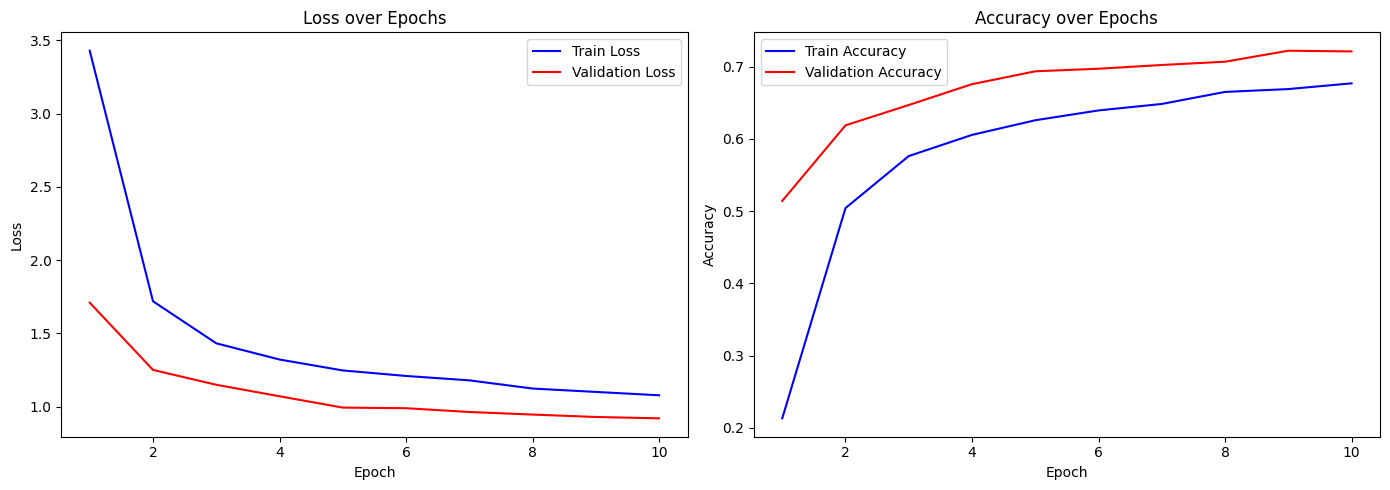

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Final Test Data Predictions:

In [31]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Get predictions
cnn_preds, test_labels = get_predictions(model, test_loader, device)
transfer_preds, _ = get_predictions(model1, test_loader, device)

### Differences:

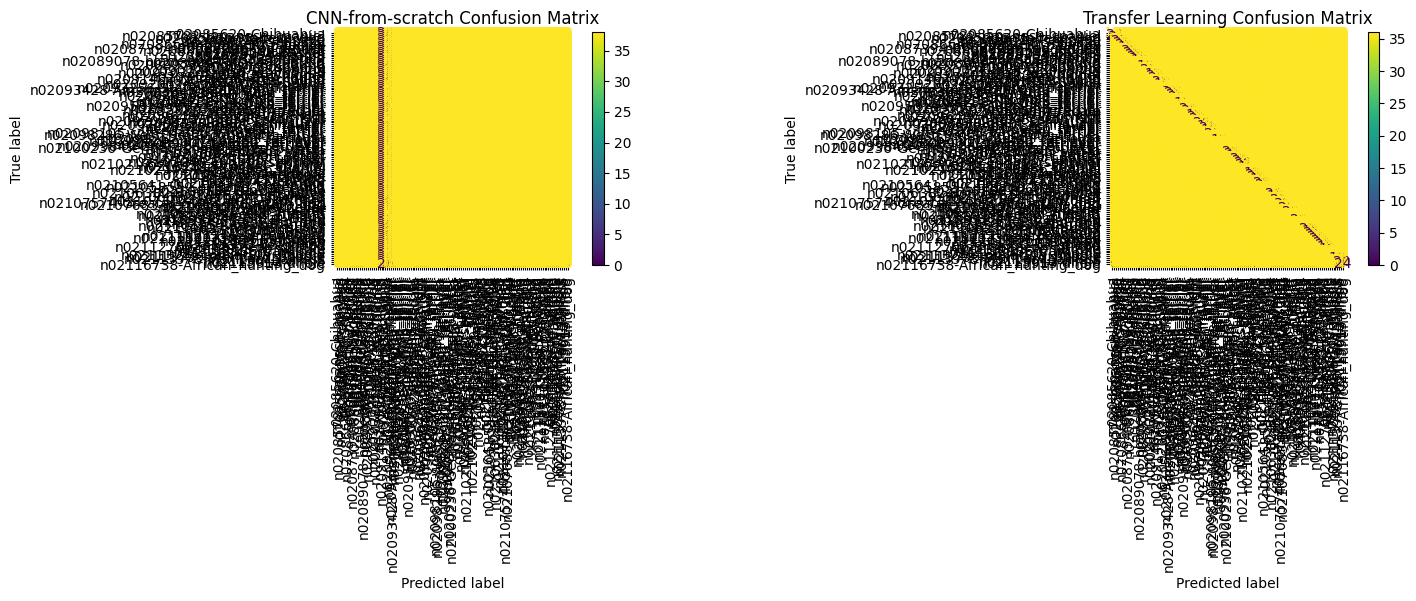

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# CNN Confusion Matrix
plt.subplot(1, 2, 1)
cm_cnn = confusion_matrix(test_labels, cnn_preds)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)
disp_cnn.plot(ax=plt.gca(), xticks_rotation='vertical')
plt.title('CNN-from-scratch Confusion Matrix')

# Transfer Learning Confusion Matrix
plt.subplot(1, 2, 2)
cm_transfer = confusion_matrix(test_labels, transfer_preds)
disp_transfer = ConfusionMatrixDisplay(confusion_matrix=cm_transfer, display_labels=class_names)
disp_transfer.plot(ax=plt.gca(), xticks_rotation='vertical')
plt.title('Transfer Learning Confusion Matrix')

plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import accuracy_score

cnn_acc = accuracy_score(test_labels, cnn_preds)
transfer_acc = accuracy_score(test_labels, transfer_preds)

print(f"CNN-from-scratch Test Accuracy: {cnn_acc:.4f}")
print(f"Transfer Learning Test Accuracy: {transfer_acc:.4f}")

CNN-from-scratch Test Accuracy: 0.0097
Transfer Learning Test Accuracy: 0.7049


### Basic CNN performs very poorly as it has way less dimensions and needs more epochs and training time which is not available for me currently. Mobile net performs way better as it has more dimensions to be abe to learn the dimensions in the data.